# 1. Importar libs e carregar os DataFrames

In [1]:
from bibliotecas.eda import *
from bibliotecas.limpeza import *

In [2]:
import missingno as msno
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import geopandas as gpd
import time
from datetime import datetime
from datetime import timedelta
%matplotlib inline

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# preprocessing and pipeline
from sklearn.preprocessing import (StandardScaler,  # REESCALANDO FEATURES
                                   MinMaxScaler, 
                                   RobustScaler, 
                                   LabelEncoder)
from sklearn.pipeline import Pipeline # CRIANDO PIPELINES
from sklearn import set_config


# feature selection
from sklearn.feature_selection import SelectKBest, chi2, RFE  # SELEÇÃO DE FEATURES
from sklearn.ensemble import RandomForestClassifier

# mode selection and metrics
from sklearn.model_selection import (train_test_split,  # METRICAS
                                     GridSearchCV,
                                     KFold,
                                     cross_val_score)
from sklearn import metrics

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             precision_score, 
                             recall_score,
                             confusion_matrix,
                             roc_auc_score,
                             roc_curve
                            )

# warnings option
import warnings
warnings.filterwarnings('ignore')

# 2 - Lendo Arquivos

In [3]:
df_obitos = pd.read_csv('dados/casos_obitos_doencas_preexistentes.csv', encoding ='utf8', delimiter=";")
df_municipios = pd.read_csv('dados/Codigo_Nome_Municipios.txt', encoding ='ANSI', sep=';')
df_coordenadas = pd.read_csv('dados/Sedes_Coordenadas_Municipios.csv', encoding ='utf8', delimiter=";")

## 2.1 - Ver os dataframes

In [4]:
df_obitos.head(3)

,nome_munic,codigo_ibge,idade,cs_sexo,diagnostico_covid19,data_inicio_sintomas,obito,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,outros_fatores_de_risco,pneumopatia,puerpera,sindrome_de_down
0,São Paulo,3550308,45.0,MASCULINO,CONFIRMADO,2021-03-18T00:00:00Z,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO
1,São Paulo,3550308,39.0,MASCULINO,CONFIRMADO,2021-07-07T00:00:00Z,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO
2,São Paulo,3550308,59.0,MASCULINO,CONFIRMADO,2021-01-20T00:00:00Z,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO


In [5]:
df_municipios.head(3)

,CODIGO MUNICIPIO,UF,NOME MUNICIPIO
0,110001,RO,Alta Floresta d`Oeste
1,110002,RO,Ariquemes
2,110003,RO,Cabixi


In [6]:
df_coordenadas.head(3)

,CODIGO MUNICIPIO,LATITUDE,LONGITUDE
0,520005,-16.75,-49.43
1,310010,-18.48,-47.40
2,520010,-16.20,-48.70


# 3. Limpeza de dados 

In [7]:
df_obitos.describe().T

,count,mean,std,min,25%,50%,75%,max
codigo_ibge,4412182.0,3.534491e+06,17281.778729,3500105.0,3518800.0,3540804.0,3550308.0,3599999.0
idade,4391965.0,4.093999e+01,17.637483,0.0,28.0,40.0,53.0,136.0
obito,4412182.0,3.456702e-02,0.182680,0.0,0.0,0.0,0.0,1.0


Analizando as tabelas acima não parece haver nenhuma incosistência significativa no DataFrame. 

A unica variável que não está totalmente preenchida é a variavel "Income"
As colunas 'Z_CostContact', 'Z_Revenue' são constantes 

## 3.1 - Linhas duplicada, colunas duplicadas e colunas constantes

In [8]:
linhas_duplicadas(df_obitos)

Existem 1404170 linhas duplicadas


Como não existe idenficação de pacientes, é esperado que o número de duplicados seja alto

In [9]:
linhas_duplicadas(df_coordenadas)

Não há linhas duplicadas no conjunto de dados.


In [10]:
linhas_duplicadas(df_municipios)

Não há linhas duplicadas no conjunto de dados.


In [ ]:
colunas_duplicadas(df_obitos)

In [ ]:
colunas_duplicadas(df_municipios)

In [ ]:
colunas_duplicadas(df_coordenadas)

In [ ]:
colunas_constantes(df_obitos)

In [ ]:
colunas_constantes(df_municipios)

In [ ]:
colunas_constantes(df_coordenadas)

In [12]:
def identify_cols_low_variance(df, low_variance_threshold):
    '''
    recebe um df
    retorna uma lista de colunas com baixa variancia
    -
    df - > dataframe a ser analisado
    low_variance_threshold -> 0.001 (indicado)
    '''
    # Inicializa scaler
    scaler = MinMaxScaler()
    # Seleciona apenas variáveis numéricas
    df_numericas = df.select_dtypes(exclude=['object'])
    # Faz scaling das variáveis
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_numericas),
        columns=df_numericas.columns
    )
    
    colunas_baixa_variancia = []
    for col in df_scaled.columns:
        if df_scaled[col].var() < low_variance_threshold:
            colunas_baixa_variancia.append(col)
            
    return colunas_baixa_variancia

In [13]:
colunas_baixa_variancia = identify_cols_low_variance(df_obitos, low_variance_threshold=0.001)

if len(colunas_baixa_variancia) > 0:
    print('Colunas com baixa variância:', colunas_baixa_variancia)
    df_train.drop(colunas_baixa_variancia, axis=1, inplace=True)
    
else:
    print('Não há colunas com baixa variância no conjunto de dados.')

Não há colunas com baixa variância no conjunto de dados.


### tratamento de nulos

In [14]:
def checa_nulos(df):
    # Checando colunas com nulos
    coluna_nulos = pd.Series(df.isnull().sum(), name='nulos')

    coluna_nulosperc = pd.Series(100 * (df.isnull().sum()/ df.shape[0]), name='%')

    df_nulos = pd.merge(coluna_nulos, coluna_nulosperc, right_index = True,
                   left_index = True).round(2)
    return df_nulos

In [16]:
checa_nulos(df_obitos)

,nulos,%
nome_munic,0,0.00
codigo_ibge,0,0.00
idade,20217,0.46
cs_sexo,1,0.00
diagnostico_covid19,0,0.00
data_inicio_sintomas,44985,1.02
obito,0,0.00
asma,0,0.00
cardiopatia,0,0.00
diabetes,0,0.00


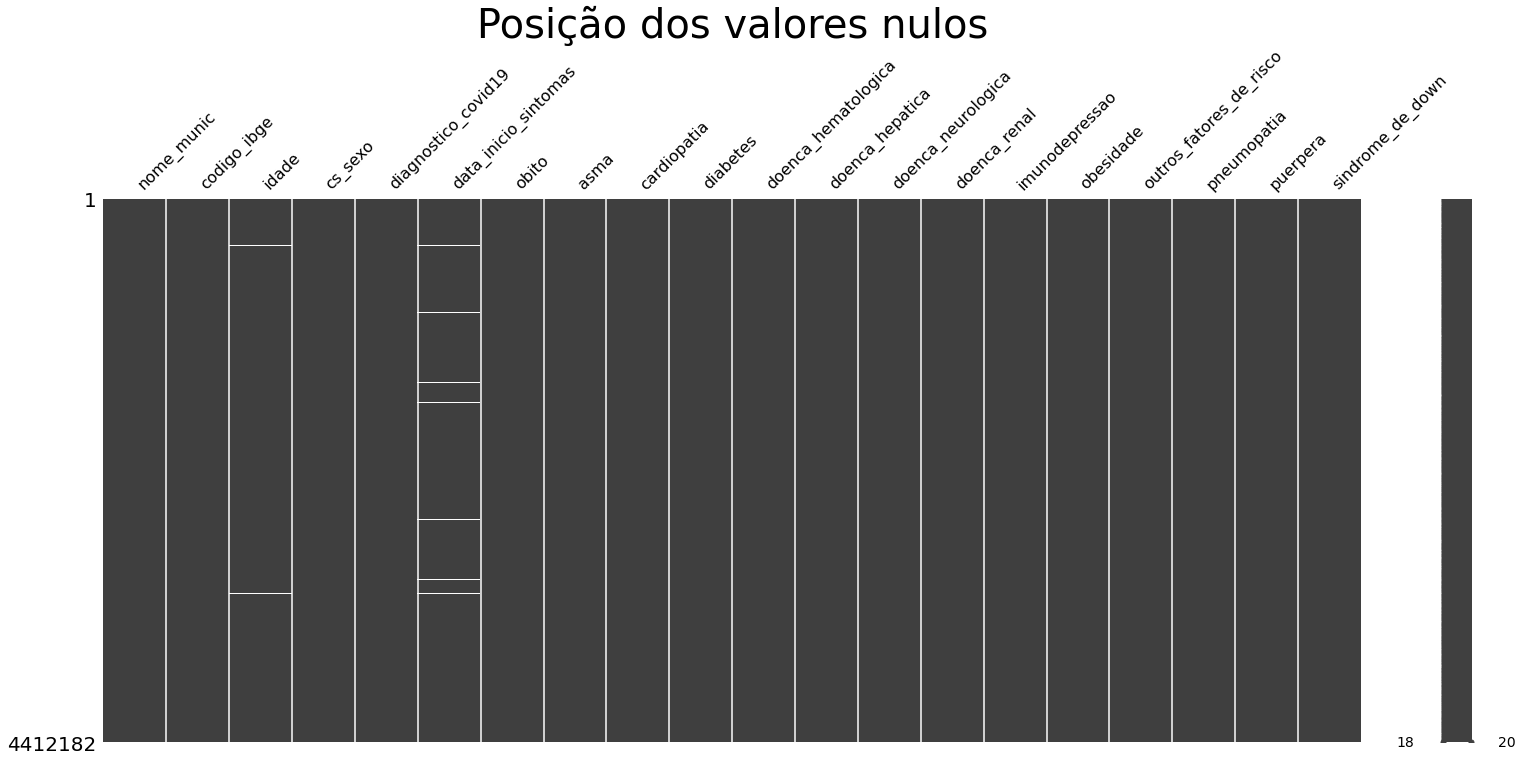

In [17]:
%config InlineBackend.figure_format = 'png'
msno.matrix(df_obitos)
plt.title(label ='Posição dos valores nulos',fontsize=40)
plt.show()

In [18]:
checa_nulos(df_municipios)

,nulos,%
CODIGO MUNICIPIO,0,0.0
UF,0,0.0
NOME MUNICIPIO,0,0.0


In [19]:
checa_nulos(df_coordenadas)

,nulos,%
CODIGO MUNICIPIO,0,0.0
LATITUDE,0,0.0
LONGITUDE,0,0.0


Apenas as colunas "idade" e "data_inicio_sintomas" e 'sexo' da tabela df_obito possuem nulos e removeremos os dados pois queremos saber a idade das pessoas que contrairam covid dentro de um certo periodo para determinar o risco de suas comorbidades

In [20]:
df_nonan = df_obitos.dropna(subset = ['idade','data_inicio_sintomas','cs_sexo'])

## 3.2 - Outliers

### 3.2.1 - Feature Idade 

Identificado outliers / erros de digitacao - 95 observacoes com idade acima de 110 anos.

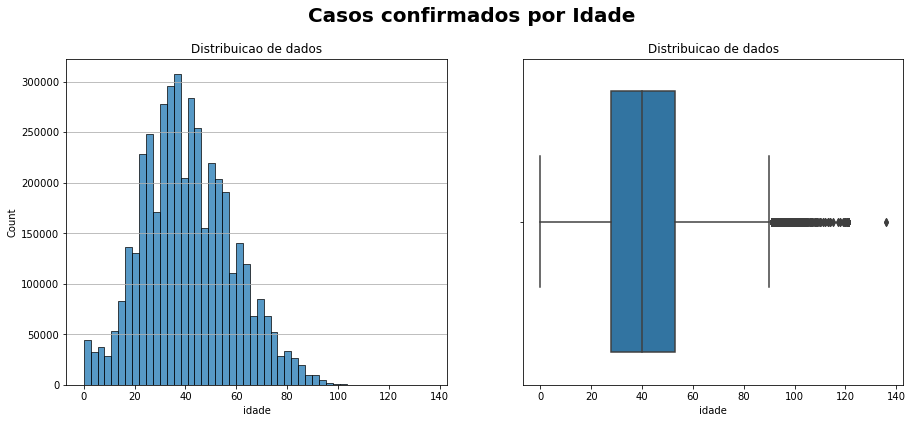

In [22]:
fig, ax = plt.subplots (1,2, figsize = (15,6))
ax[0].set_title(f'Distribuicao de dados')
ax[1].set_title(f'Distribuicao de dados')

fig.suptitle (f'Casos confirmados por Idade', fontsize = 20, fontweight = 'bold', y =1)
sns.histplot(data = df_nonan.idade,bins = 50, ax=ax[0])
ax[0].grid(axis = 'y')


ax = sns.boxplot(x=df_nonan["idade"], ax=ax[1])
# ax[1].set_title(f'Distribuicao de dados')
plt.show()

In [23]:
X_maior_100=pd.DataFrame(df_nonan.query('idade > 110'))

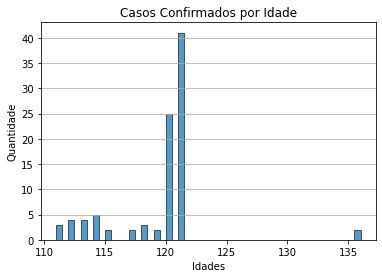

In [24]:
fig, ax = plt.subplots ()
sns.histplot(data = X_maior_100.idade,bins = 50)
ax.grid(axis = 'y')

# formatando a imagem
ax.set_title('Casos Confirmados por Idade')
ax.set_xlabel('Idades')
ax.set_ylabel('Quantidade')
plt.show()

In [25]:
print('Temos ao todo, ', X_maior_100.shape[0],'observações com idade registradas acima de 110 anos')

Temos ao todo,  93 observações com idade registradas acima de 110 anos


Tomada de decisão para para analise do DataSet foi de retirar as observações e considerar os registros como erros.

In [26]:
# removendo entradas de pessoas com mais de 110 anos 
remove = df_nonan.loc[(df_nonan['idade'] > 110)]
df_nonan = df_nonan.drop(remove.index)

### 3.2.2 - Feature cs_sexo 

In [27]:
list(df_nonan['cs_sexo'].unique())

['MASCULINO', 'FEMININO', 'INDEFINIDO', 'IGNORADO']

In [28]:
df_sexo = df_nonan.query('cs_sexo == "INDEFINIDO" or cs_sexo == "IGNORADO"')
print(f'Temos {df_sexo.shape[0]} linhas com cs_sexo INDEFINIDO ou IGNORADO')

Temos 864 linhas com cs_sexo INDEFINIDO ou IGNORADO


In [29]:
df_Puerpera = df_obitos.loc[(df_obitos['puerpera'] == "SIM") & (df_obitos['cs_sexo'] == "INDEFINIDO") & (df_obitos['cs_sexo'] == "IGNORADO")]
print(f'Puerperas classificads como "INDEFINIDO" ou "IGNORADO": {df_Puerpera.shape[0]}')

Puerperas classificads como "INDEFINIDO" ou "IGNORADO": 0


Por conta da pequena quantidade de cs_sexo COMO "INDEFINIDO" ou "IGNORADO" decidimos remover essas linhas

In [30]:
df_nonan = df_nonan.drop(df_nonan[
    (df_nonan.cs_sexo == "INDEFINIDO") | 
    (df_nonan.cs_sexo == "IGNORADO") ].index)

In [41]:
perc = pd.Series(df_nonan['cs_sexo']).value_counts()       
print(( perc / len(df_nonan['cs_sexo']))*100) 

FEMININO     53.137789
MASCULINO    46.862211
Name: cs_sexo, dtype: float64


A variavél sexo está equilibrada em relacao a populacao global que apresenta uma maior quantidade de mulheres em relacao a homens


## Analise da Feature Target - obito

In [33]:
list(df_nonan['obito'].unique())

[0, 1]

In [45]:
freq = df_nonan['obito'].value_counts()
perc = 100 *(pd.Series(df_nonan['obito'], name='%').value_counts() / len(df_nonan['obito']))   

In [46]:
obito = pd.merge(freq, perc, right_index = True,
               left_index = True).round(2)
obito

,obito,%
0,4208562,96.5
1,152502,3.5


In [49]:
100 *(df_obitos.shape[0]/46649132)

9.458229576490298

O grande Desequilibrio da variavel target pode ser entendido que apesar da alta taxa de contaminacao (10 % de toda a poulacao do estado de São Paulo foi contaminada até a data observada)[1] o virus da SARS-COV19 apresenta uma baixa taxa de letalidade.

Do ponto de vista de modelagem esse desequilibrio pode ser prejudicial a modelagem

# Exportando o dataframe limpo

In [52]:
df_nonan.to_pickle('dados/df_nonan.pkl')

# Referencias

[1] Panorama Populaciona do Etado de São Paulo. IBGE. Disponível em: <https://cidades.ibge.gov.br/brasil/sp/panorama>. Acesso em: 10 de Fev. de 2022